In [7]:
# !nvcc --version
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1
CUDA available: False


In [8]:
import torch
from fastai.vision.all import *
import fastai
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
print("torch", torch.__version__, "fastai", fastai.__version__)

torch 2.5.1 fastai 2.7.18


In [10]:
#path = Path("/kaggle/input/charts/labeled-images")
# /Users/ivostoyanov/Documents/github/PY/TBPY/labeled-images
#import pathlib
#dir = "/Users/ivostoyanov/Documents/github/PY/TBPY/labeled-images"
path = Path("/Users/ivostoyanov/Documents/github/PY/TBPY/labeled-images")
labels = [p.name for p in path.ls()]
print(labels)
#files = get_image_files(path)
#len(files)

['LONG_PUT', '.DS_Store', 'DELETE', 'SKIP', 'SHORT_PUT', 'SHORT_CALL', 'CHOP', 'RANGE', 'LONG_CALL']


In [11]:
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [13]:
def get_data(path, presize=256, resize=224):
    dls = DataBlock(
        blocks=[ImageBlock, CategoryBlock],
        get_items=get_image_files,
        get_y = parent_label,
        splitter=RandomSplitter(),
        item_tfms = [Resize(presize, ResizeMethod.Squish)],
        #item_tfms = [RandomResizedCrop(presize, min_scale=0.7)],
        #batch_tfms=[*aug_transforms(min_scale=0.7, size=resize), Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=64)
    return dls

labels ['CHOP', 'LONG_CALL', 'LONG_PUT', 'RANGE', 'SHORT_CALL', 'SHORT_PUT', 'SKIP']


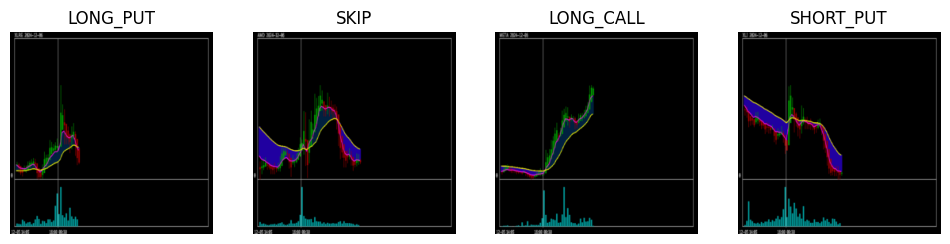

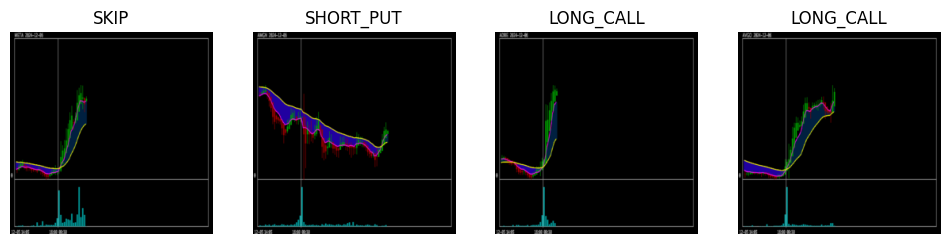

In [15]:
dls = get_data(path)
print("labels", dls.vocab)
dls.train.show_batch(max_n=4, nrows=1)
dls.valid.show_batch(max_n=4, nrows=1)

In [7]:
def get_learner(**kwargs):
    learner = Learner(dls, xresnet34(n_out=len(labels)), metrics=accuracy)
    # Explicitly move to device
    learner.model = learner.model.to(device)
    learner.dls.to(device)
    return learner

In [8]:
learn = get_learner()
print("Model device:", next(learn.model.parameters()).device)
print("Learner type:", type(learn))
print("Model type:", type(learn.model))

Model device: cuda:0
Learner type: <class 'fastai.learner.Learner'>
Model type: <class 'fastai.vision.models.xresnet.XResNet'>


In [21]:
#learn.lr_find()
#learn.load('/kaggle/working/models/chart1')

Path('/kaggle/working/chart2.pth.pth')

In [9]:
learn.fit_one_cycle(5, lr_max=0.001)

epoch,train_loss,valid_loss,accuracy,time
0,1.799014,1.732974,0.443333,00:15
1,1.564443,2.125082,0.156667,00:13
2,1.412193,1.305137,0.493333,00:13
3,1.291943,1.144153,0.536667,00:13
4,1.202516,1.077281,0.533333,00:13


In [12]:
learn.save('/kaggle/working/models/chart2.pth')

Path('/kaggle/working/models/chart2.pth.pth')

In [11]:
model = learn.model
model.eval()
# Convert to TorchScript
scripted_model = torch.jit.script(model)
# Save the TorchScript model
scripted_model.save('/kaggle/working/models/chart2.pt')

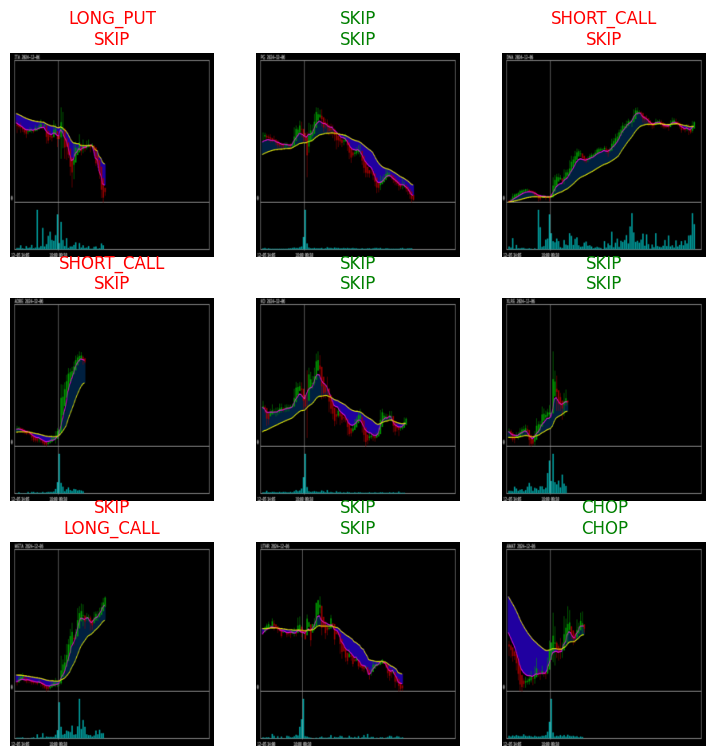

In [10]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()